## **UNITED AIRLINES CALL CENTER METRICS**

**United Airlines is committed to becoming the best airline in aviation history by providing world-class customer service. A critical aspect of achieving this goal is optimizing the performance of our call center operations, which are essential for resolving customer issues swiftly and efficiently. However, we are currently facing key challenges in improving call center metrics, particularly:**
- **High Average Handle Time (AHT): Leading to extended customer interactions and delayed resolutions.**
- **Long Average Speed to Answer (AST): Resulting in longer wait times for customers, impacting their overall satisfaction.**
- **To enhance customer experience and streamline operations, we must identify the inefficiencies driving these prolonged metrics and implement strategies to improve customer satisfaction, reduce escalations, and boost overall operational efficiency.**


# Importing Libraries

In [1]:
import pandas as pd        
import numpy as np         
import matplotlib.pyplot as plt 
import seaborn as sns      

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [3]:
calls = pd.read_csv('callsf0d4f5a.csv')

In [4]:
customers = pd.read_csv('customers2afd6ea.csv')

In [5]:
reason = pd.read_csv('reason18315ff.csv')

In [6]:
sentiments = pd.read_csv('sentiment_statisticscc1e57a.csv')

In [7]:
test = pd.read_csv('testbc7185d.csv')

In [8]:
# print size of the datasets : (rows,columns)
datasets = {'calls':calls, 'customers':customers, 'reason':reason, 'sentiment statistics':sentiments}
for name, data in datasets.items():
    print(name)
    print('shape: ',data.shape)

calls
shape:  (71810, 7)
customers
shape:  (71810, 3)
reason
shape:  (66653, 2)
sentiment statistics
shape:  (71810, 6)


# EDA

In [9]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('viridis')

In [10]:
calls.head(2)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...


In [11]:
customers.head(2)

,customer_id,customer_name,elite_level_code
0,2033123310,Matthew Foster,4.0
1,8186702651,Tammy Walters,NaN


In [12]:
reason.head(2)

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking


In [13]:
sentiments.head(2)

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35


In [14]:
# merge the dataframes
df = pd.merge(calls, customers, on='customer_id', how='left')
df = pd.merge(df, sentiments, on=['call_id', 'agent_id'], how='left')
df = pd.merge(df, reason, on='call_id', how='left')

In [15]:
df.head(2)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,neutral,angry,-0.04,0.39,Voluntary Cancel
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,calm,neutral,0.02,0.35,Booking


In [16]:
# shape of dataset
df.shape

(71810, 14)

In [17]:
# dtypes in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71810 non-null  int64  
 1   customer_id              71810 non-null  int64  
 2   agent_id                 71810 non-null  int64  
 3   call_start_datetime      71810 non-null  object 
 4   agent_assigned_datetime  71810 non-null  object 
 5   call_end_datetime        71810 non-null  object 
 6   call_transcript          71810 non-null  object 
 7   customer_name            71810 non-null  object 
 8   elite_level_code         46043 non-null  float64
 9   agent_tone               71593 non-null  object 
 10  customer_tone            71810 non-null  object 
 11  average_sentiment        71701 non-null  float64
 12  silence_percent_average  71810 non-null  float64
 13  primary_call_reason      66653 non-null  object 
dtypes: float64(3), int64(3

In [18]:
# datetime columns have dtype='object' , should be converted
df['call_start_datetime'] = pd.to_datetime(df['call_start_datetime'])
df['agent_assigned_datetime'] = pd.to_datetime(df['agent_assigned_datetime'])
df['call_end_datetime'] = pd.to_datetime(df['call_end_datetime'])

In [19]:
# are there any missing values in dataframe
df.isnull().sum()

call_id                        0
customer_id                    0
agent_id                       0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
customer_name                  0
elite_level_code           25767
agent_tone                   217
customer_tone                  0
average_sentiment            109
silence_percent_average        0
primary_call_reason         5157
dtype: int64

Observations:
- as expected, a lot of customers don't have any elite_level_code assigned in dataset
- very few rows miss agent_tone, average_sentiment column values
- a lot of records do not have primary_call_reason 

# Goals for this notebook:
- Define AHT and AST
- Explore factors contributing to long AHT
-- Agent performance, call types and Sentiment
- Key drivers of long AST and AHT , during high volume call periods
- Find percentage difference between AHT for the most least frequent call reasons

# Creating Features

**AHT (Average Handle Time):**
- Time from when the agent picks up the call to when they hang up
- Formula:
- AHT = Total Handle Time / Total Number of Calls

**AST (Average Speed to Answer):**
- Time spent by the customer in queue till the agent answers the call
- Formula:
- AST = Total Waiting Time / Total Number of Calls

In [20]:
# handle_time = call_end_datetime - agent_assigned_datetime, in seconds
df['handle_time'] = (df['call_end_datetime'] - df['agent_assigned_datetime']).dt.total_seconds()

# speed_to_answer = agent_assigned_datetime - call_start_datetime, in seconds
df['speed_to_answer'] = (df['agent_assigned_datetime'] - df['call_start_datetime']).dt.total_seconds()

In [21]:
df.head(2)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason,handle_time,speed_to_answer
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,neutral,angry,-0.04,0.39,Voluntary Cancel,1860.0,420.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,calm,neutral,0.02,0.35,Booking,720.0,180.0


## AHT  (Average Handle Time)

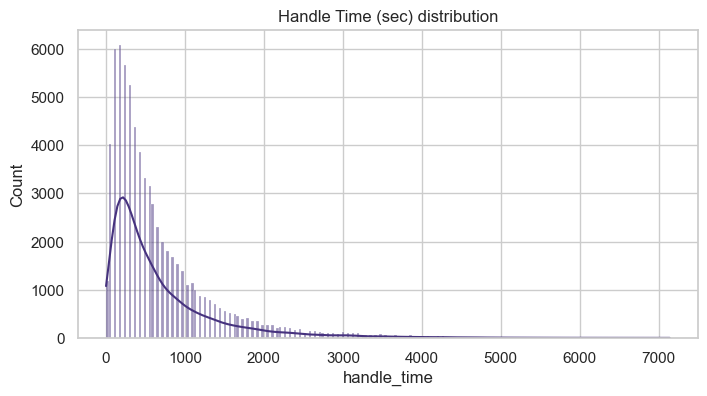

In [22]:
# lets see the distribution of handle_time for each call:
plt.figure(figsize=(8,4))
sns.histplot(df.handle_time,kde=True)
plt.title('Handle Time (sec) distribution')
plt.show()

Right Skewed Distribution, though some outliers/extreme Customer Handle Times!

In [23]:
AHT = np.mean(df.handle_time)
print(f"AHT (Average Handle Time) is {AHT:.2f} seconds")

AHT (Average Handle Time) is 697.05 seconds


This Average Handle Time is quite high! Approximately 12 minutes, this should be low.

36.28% calls exceed 10 minutes!


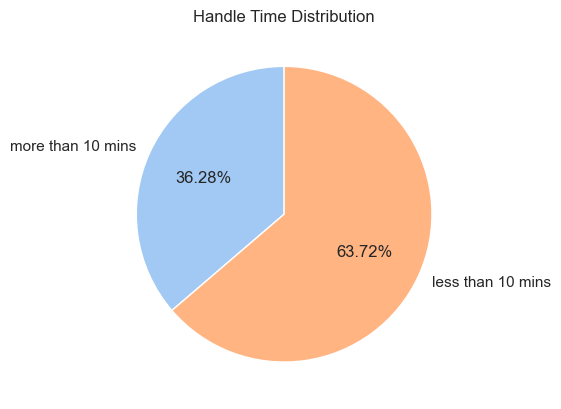

In [24]:
# what percentage of calls exceed than 10 mins(600 seconds)
more_than_600 = df[df['handle_time'] > 600].shape[0]
less_or_equal_600 = df[df['handle_time'] <= 600].shape[0]

labels = ['more than 10 mins', 'less than 10 mins']
values = [more_than_600, less_or_equal_600]

print(f'{(more_than_600/df.shape[0])*100:.2f}% calls exceed 10 minutes!')
sns.set_palette('pastel')
# pie chart
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('Handle Time Distribution')
plt.show()

For more than 30% calls, Agents handle calls for more than 10 Minutes.

## AST (Average Speed to Answer)

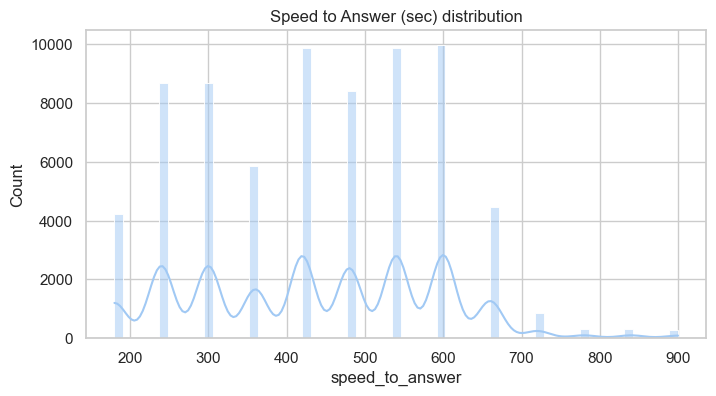

In [25]:
# lets see the distribution of speed_to_answer for each call:
plt.figure(figsize=(8,4))
sns.histplot(df.speed_to_answer,kde=True)
plt.title('Speed to Answer (sec) distribution')
plt.show()

69.95% waiting time exceeds 5 minutes!


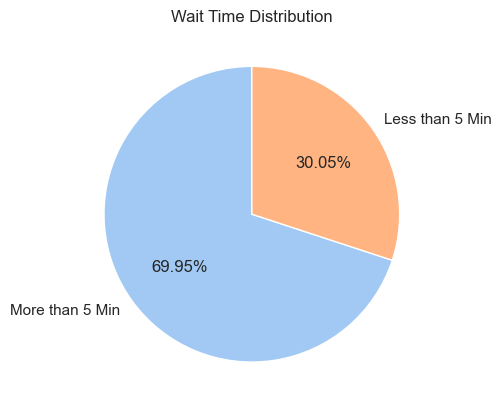

In [26]:
# finding how many customers have to wait for more than 5 minutes(300 seconds)
wait_more_than_5mins = df[df.speed_to_answer>300].shape[0]/df.shape[0]
wait_less_than_5mins = df[df.speed_to_answer<=300].shape[0]/df.shape[0]
labels = ['More than 5 Min','Less than 5 Min']
values = [wait_more_than_5mins,wait_less_than_5mins]

print(f'{(wait_more_than_5mins)*100:.2f}% waiting time exceeds 5 minutes!')
sns.set_palette('pastel')
# pie chart
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('Wait Time Distribution')
plt.show()

In [27]:
AST = np.mean(df.speed_to_answer)
print(f"AST (Average Speed to Answer) is {AST:.2f} seconds")

AST (Average Speed to Answer) is 437.07 seconds


AST too , is very high , more than 7 minutes !

## drop redundant columns

In [28]:
df.head(2)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason,handle_time,speed_to_answer
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,neutral,angry,-0.04,0.39,Voluntary Cancel,1860.0,420.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,calm,neutral,0.02,0.35,Booking,720.0,180.0


In [29]:
# drop columns which are not required:
df.drop(['call_end_datetime','agent_assigned_datetime','customer_name'],axis=1,inplace=True)

## Agent Performance and AHT 

In [30]:
# metrics: agent_tone, silence_percent_average, handle_time

### Agent tone

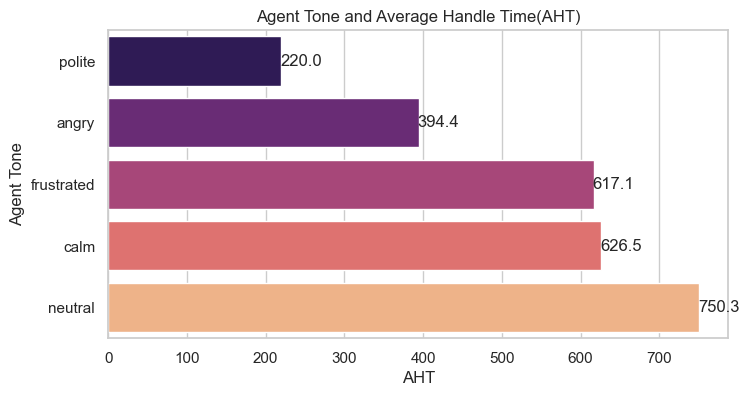

In [31]:
# agent_tone vs AHT
df_agent_tone = df.groupby('agent_tone')['handle_time'].mean().reset_index().sort_values(by='handle_time')

plt.figure(figsize=(8,4))
ax = sns.barplot(df_agent_tone,x='handle_time',y='agent_tone',palette='magma')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}', 
                (p.get_width()+25, p.get_y() + p.get_height() / 2), 
                ha='center', va='center')
plt.xlabel('AHT')
plt.ylabel('Agent Tone')
plt.title('Agent Tone and Average Handle Time(AHT)')
plt.show()

**Observations**
- AHT was lowest when Agent Tone was Polite.
- Surprisingly Neutral , Calm Agent tone had highest AHT.
- When Agent was Angry/ Frustrated AHT was low, though this is not recommended.

### Silence Percent Average

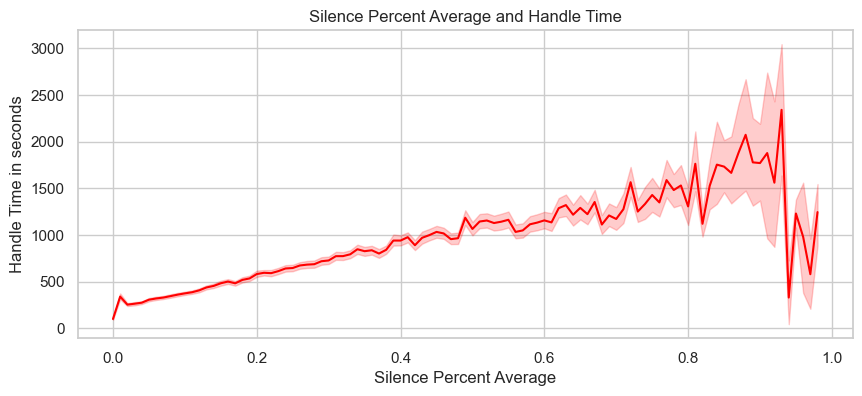

In [32]:
# silence_percent_average vs AHT
#df_agent_tone = df.groupby('agent_tone')['handle_time'].mean().reset_index().sort_values(by='handle_time')

plt.figure(figsize=(10,4))

sns.lineplot(x=df.silence_percent_average,y=df.handle_time,color='red')
plt.xlabel('Silence Percent Average')
plt.ylabel('Handle Time in seconds')
plt.title('Silence Percent Average and Handle Time')
plt.show()

**Observations**
- A lot of calls have high Silence Percentage,
- and most of these calls have high Handle Time
- Silence between Conversations must be minimized!

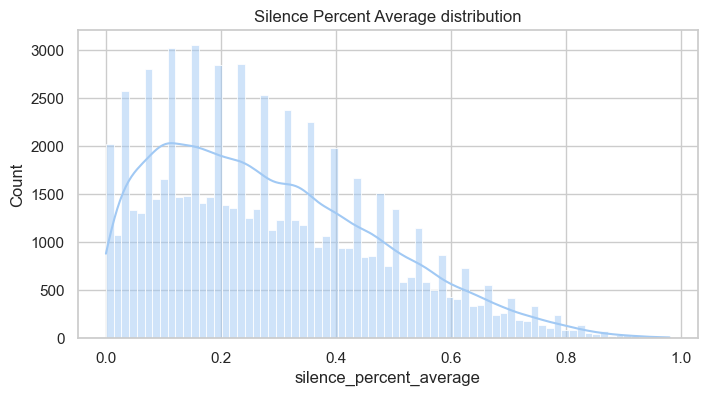

In [33]:
# distribution of Silence Percent Average
plt.figure(figsize=(8,4))
sns.histplot(df.silence_percent_average,kde=True)
plt.title('Silence Percent Average distribution')
plt.show()

 14.59% calls have more than 50% time as Silence!


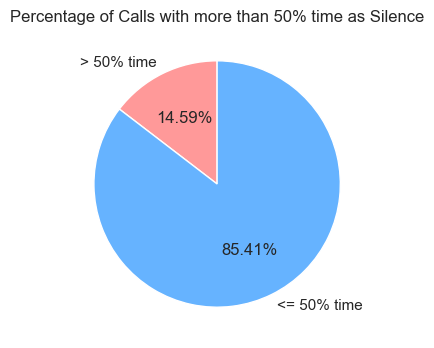

In [34]:
# how many calls have more than 50% of time as silence?
greater_than_05 = df[df['silence_percent_average'] > 0.5].shape[0]
less_or_equal_05 = df[df['silence_percent_average'] <= 0.5].shape[0]

labels = ['> 50% time', '<= 50% time']
values = [greater_than_05, less_or_equal_05]

print(f"{(greater_than_05/df.shape[0])*100: .2f}% calls have more than 50% time as Silence!")

plt.figure(figsize=(4, 4))
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Calls with more than 50% time as Silence')
plt.show()

## Call Types and AHT

In [51]:
df.primary_call_reason.unique()

array(['Voluntary  Cancel', 'Booking', 'IRROPS', 'Upgrade', 'Seating',
       'Mileage   Plus', 'Checkout', nan, 'Voluntary   Change',
       'Post Flight', 'Check In', 'Other  Topics', 'Communications',
       'Schedule Change', 'Products & Services', 'IRROPS  ',
       'Digital   Support', 'Seating  ', 'Disability',
       'Unaccompanied Minor', ' Baggage', 'Traveler  Updates',
       'Communications  ', 'ETC', 'Upgrade  ', 'Unaccompanied Minor  ',
       'Voluntary Change', 'Voluntary Change  ', 'Checkout  ',
       'Mileage Plus', 'Mileage Plus  ', 'Booking  ', 'Baggage  ',
       'Post-Flight', 'Post-Flight  ', 'Schedule Change  ', 'Baggage',
       'Traveler Updates', 'Voluntary Cancel', 'Check-In',
       'Products and Services', 'Check-In  ', 'Other Topics',
       'Other Topics  ', 'ETC  ', 'Disability  ', 'Digital Support',
       'Digital Support  ', 'Voluntary Cancel  ',
       'Products and Services  ', 'Traveler Updates  ',
       'Traveler   Updates', 'Digital  Support',

In [65]:
# clean extra spaces in this column:
df.primary_call_reason = df.primary_call_reason.str.strip()
df.primary_call_reason = df.primary_call_reason.str.replace('-', ' ')
df.primary_call_reason = df.primary_call_reason.str.replace(r'\s+', ' ', regex=True).str.strip()
df.primary_call_reason = df.primary_call_reason.str.replace('&', 'and')

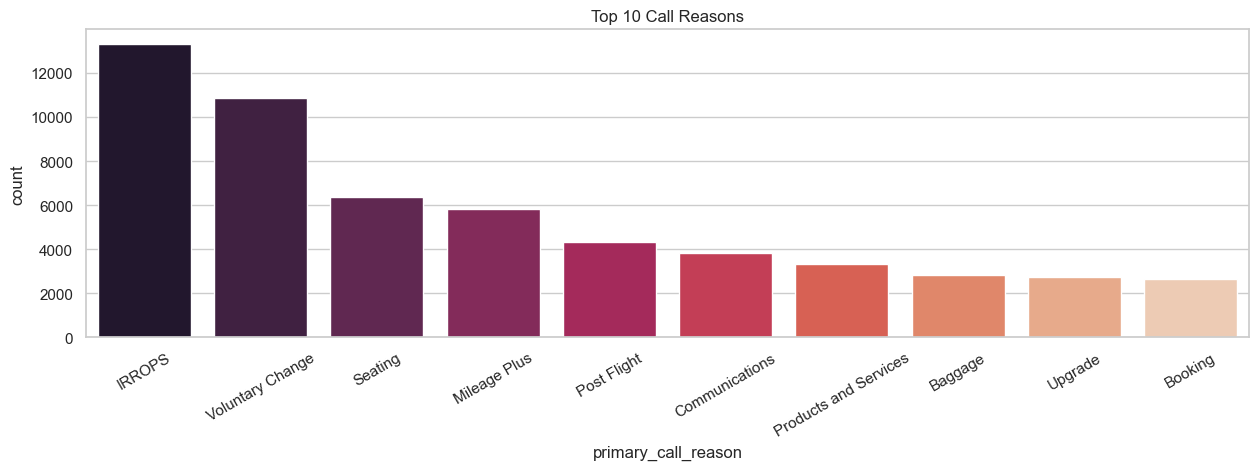

In [66]:
top_10_callreason = df.primary_call_reason.value_counts().reset_index()[:10]
plt.figure(figsize=(15,4))
sns.barplot(top_10_callreason,x='primary_call_reason',y='count',palette='rocket')
plt.title('Top 10 Call Reasons')
plt.xticks(rotation=30)
plt.show()

In [67]:
df.primary_call_reason.unique()

array(['Voluntary Cancel', 'Booking', 'IRROPS', 'Upgrade', 'Seating',
       'Mileage Plus', 'Checkout', nan, 'Voluntary Change', 'Post Flight',
       'Check In', 'Other Topics', 'Communications', 'Schedule Change',
       'Products and Services', 'Digital Support', 'Disability',
       'Unaccompanied Minor', 'Baggage', 'Traveler Updates', 'ETC'],
      dtype=object)

In [69]:
# is AHT affected by call reason?

df.groupby('primary_call_reason')['handle_time'].mean().reset_index().sort_values(by='handle_time')

,primary_call_reason,handle_time
6,Disability,292.109181
0,Baggage,333.644068
10,Other Topics,350.097800
5,Digital Support,372.293878
15,Traveler Updates,393.233725
1,Booking,427.736064
14,Seating,474.994501
13,Schedule Change,490.013680
16,Unaccompanied Minor,519.230769
2,Check In,574.128151


**Observation**
- Disability, Baggage and Other topics have lowest AHT.
- Post Flight, ETC, Mileage Plus and Checkout have highest AHT.
- These sectors must be optimized in future.

## Sentiment and AHT

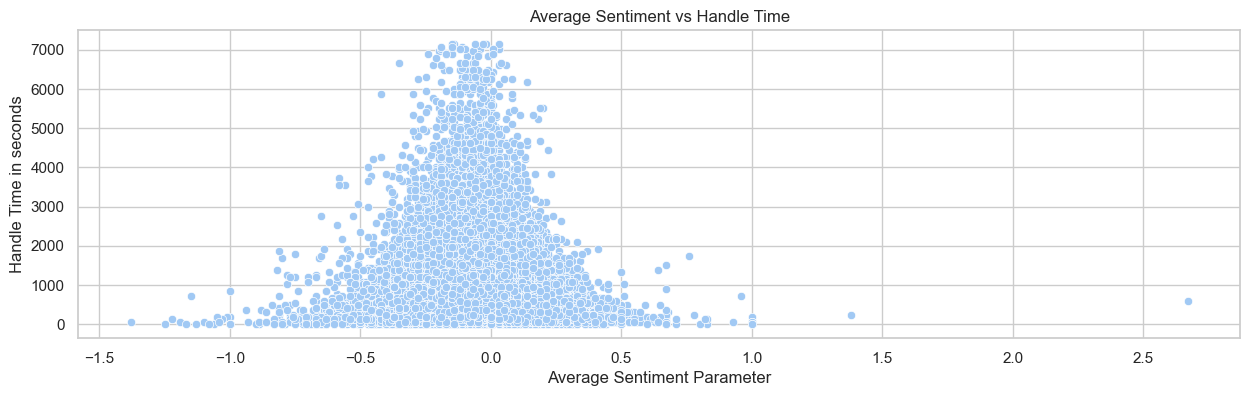

In [74]:
# average sentiment and handle time
plt.figure(figsize=(15,4))
sns.scatterplot(x=df.average_sentiment,y=df.handle_time)
plt.xlabel('Average Sentiment Parameter')
plt.ylabel('Handle Time in seconds')
plt.title('Average Sentiment vs Handle Time')
plt.show()

**Observation**
- Except a few outliers, generally Handle Time is high for Average Sentiment=0
- As indicated earlier, calm, neutral tones had similar trend.

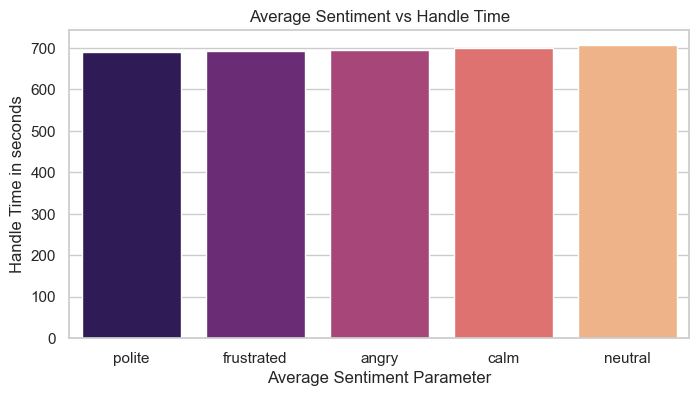

In [77]:
# Customer Tone and AHT
aht_customertone = df.groupby('customer_tone')['handle_time'].mean().reset_index().sort_values(by='handle_time')

plt.figure(figsize=(8,4))
sns.barplot(aht_customertone, x='customer_tone',y='handle_time',palette='magma')
plt.xlabel('Average Sentiment Parameter')
plt.ylabel('Handle Time in seconds')
plt.title('Average Sentiment vs Handle Time')
plt.show()

**Observation**
- Interesting, there is no relation between Customer Tone and AHT.
- This indicates that Agent Tone is a primary factor which determines AHT.
- Agents must be trained to maintain Polite tone as indicated by previous charts.

# High Volume Call Periods

In [78]:
#Key drivers of long AST and AHT , during high volume call periods

In [80]:
df.call_start_datetime

0       2024-07-31 23:56:00
1       2024-08-01 00:03:00
2       2024-07-31 23:59:00
3       2024-08-01 00:05:00
4       2024-08-01 00:04:00
                ...        
71805   2024-08-31 23:48:00
71806   2024-08-31 23:55:00
71807   2024-08-31 23:52:00
71808   2024-08-31 23:53:00
71809   2024-08-31 23:49:00
Name: call_start_datetime, Length: 71810, dtype: datetime64[ns]

In [88]:
# identifying high volume call periods
df['hour'] = df['call_start_datetime'].dt.floor('H') 
high_volume_periods = df.groupby('hour').size().reset_index(name='call_count')

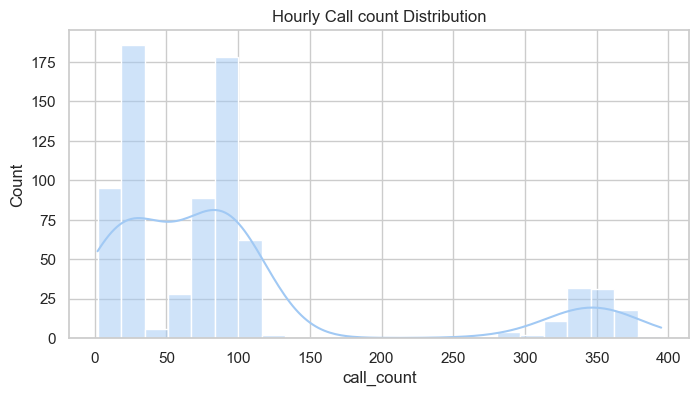

In [89]:
plt.figure(figsize=(8,4))
sns.histplot(high_volume_periods.call_count,kde=True)
plt.title('Hourly Call count Distribution')
plt.show()

In [91]:
# lets take call count> 250 as high volume period
high_volume_periods = high_volume_periods[high_volume_periods.call_count>250]
high_volume_periods

,hour,call_count
57,2024-08-03 08:00:00,323
58,2024-08-03 09:00:00,346
59,2024-08-03 10:00:00,338
60,2024-08-03 11:00:00,369
61,2024-08-03 12:00:00,369
...,...,...
735,2024-08-31 14:00:00,336
736,2024-08-31 15:00:00,338
737,2024-08-31 16:00:00,373
738,2024-08-31 17:00:00,349


In [92]:
df_volume = pd.merge(df, high_volume_periods, how='inner', on='hour')
df_volume.shape

(34171, 15)

In [94]:
# for high volume call periods:
df_volume.drop(['call_id','customer_id','agent_id','call_start_datetime','call_transcript'],axis=1,inplace=True)

In [95]:
df_volume.head()

,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason,handle_time,speed_to_answer,hour,call_count
0,2.0,frustrated,polite,-0.28,0.33,Upgrade,1380.0,180.0,2024-08-03 08:00:00,323
1,1.0,neutral,frustrated,-0.06,0.14,Booking,240.0,180.0,2024-08-03 08:00:00,323
2,3.0,calm,calm,0.13,0.68,Communications,780.0,240.0,2024-08-03 08:00:00,323
3,1.0,neutral,frustrated,-0.09,0.38,IRROPS,2220.0,360.0,2024-08-03 08:00:00,323
4,0.0,neutral,frustrated,0.00,0.53,Other Topics,60.0,180.0,2024-08-03 08:00:00,323


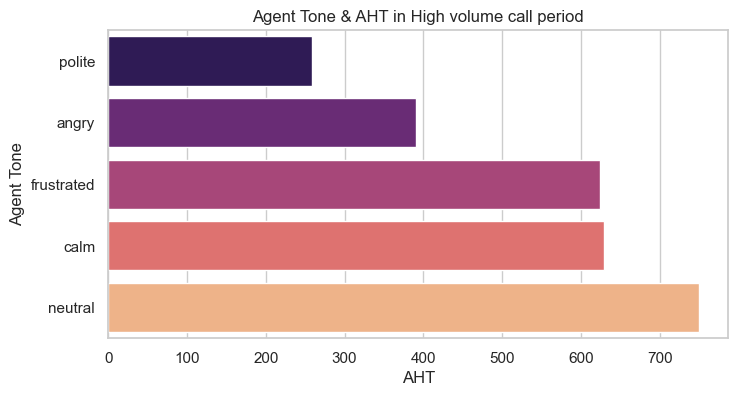

In [97]:
# agent tone in high volume call periods:
df_agent_tone = df_volume.groupby('agent_tone')['handle_time'].mean().reset_index().sort_values(by='handle_time')

plt.figure(figsize=(8,4))
sns.barplot(df_agent_tone,x='handle_time',y='agent_tone',palette='magma')
plt.xlabel('AHT')
plt.ylabel('Agent Tone')
plt.title('Agent Tone & AHT in High volume call period')
plt.show()

- similar observations in High volume call periods

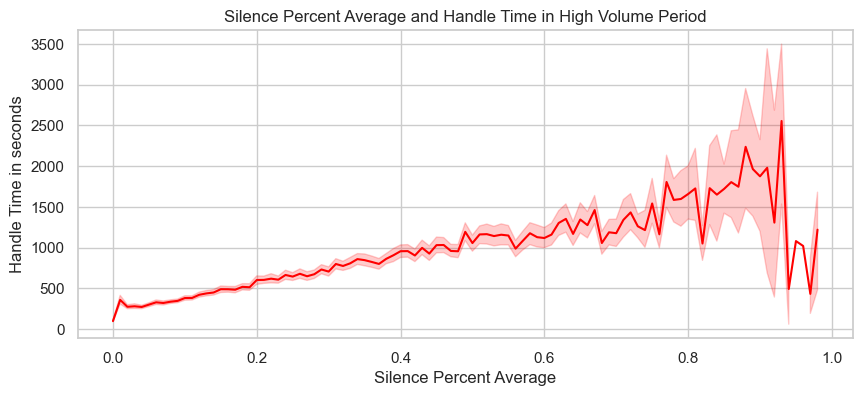

In [98]:
# silence_percent_average vs AHT High Volume call period
plt.figure(figsize=(10,4))

sns.lineplot(x=df_volume.silence_percent_average,y=df_volume.handle_time,color='red')
plt.xlabel('Silence Percent Average')
plt.ylabel('Handle Time in seconds')
plt.title('Silence Percent Average and Handle Time in High Volume Period')
plt.show()

In [100]:
# AHT and AST in high volume call period:
print(f"AHT in high Volume Call Period: {df_volume.handle_time.mean():.2f} seconds")
print(f"AST in high Volume Call Period: {df_volume.speed_to_answer.mean():.2f} seconds")

AHT in high Volume Call Period: 697.70 seconds
AST in high Volume Call Period: 436.49 seconds


**Observation**
- Similar AHT and AST in High Volume Call periods!
- AHT, AST must be lowered in High Volume periods to introduce efficiency.

# Most Frequent Call Reasons : AHT

In [104]:
df.primary_call_reason.value_counts()

primary_call_reason
IRROPS                   13311
Voluntary Change         10848
Seating                   6365
Mileage Plus              5851
Post Flight               4330
Communications            3840
Products and Services     3332
Baggage                   2832
Upgrade                   2738
Booking                   2637
Check In                  1904
Checkout                  1888
Voluntary Cancel          1607
Digital Support           1225
ETC                        952
Traveler Updates           937
Other Topics               818
Schedule Change            731
Disability                 403
Unaccompanied Minor        104
Name: count, dtype: int64

In [109]:
# Most frequent reason: IRROPS
# Least Frequent reason: Unaccompanied Minor

avg_irrops = df[df['primary_call_reason'] == 'IRROPS']['handle_time'].mean()

avg_unaccompanied_minor = df[df['primary_call_reason'] == 'Unaccompanied Minor']['handle_time'].mean()

print(f"Average handle time for IRROPS: {avg_irrops:.2f} seconds")
print(f"Average handle time for Unaccompanied Minor: {avg_unaccompanied_minor:.2f} seconds")

Average handle time for IRROPS: 785.12 seconds
Average handle time for Unaccompanied Minor: 519.23 seconds


In [110]:
# Percenateg difference:

percentage_diff = abs(avg_irrops - avg_unaccompanied_minor) / ((avg_irrops + avg_unaccompanied_minor) / 2) * 100

print(f"Percentage difference: {percentage_diff:.2f}%")

Percentage difference: 40.77%
